# **IMPORT LIBRARY**

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

2024-06-01 04:45:47.558434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 04:45:47.558610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 04:45:47.731824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **VISUALISASI IMAGES**

i. load images

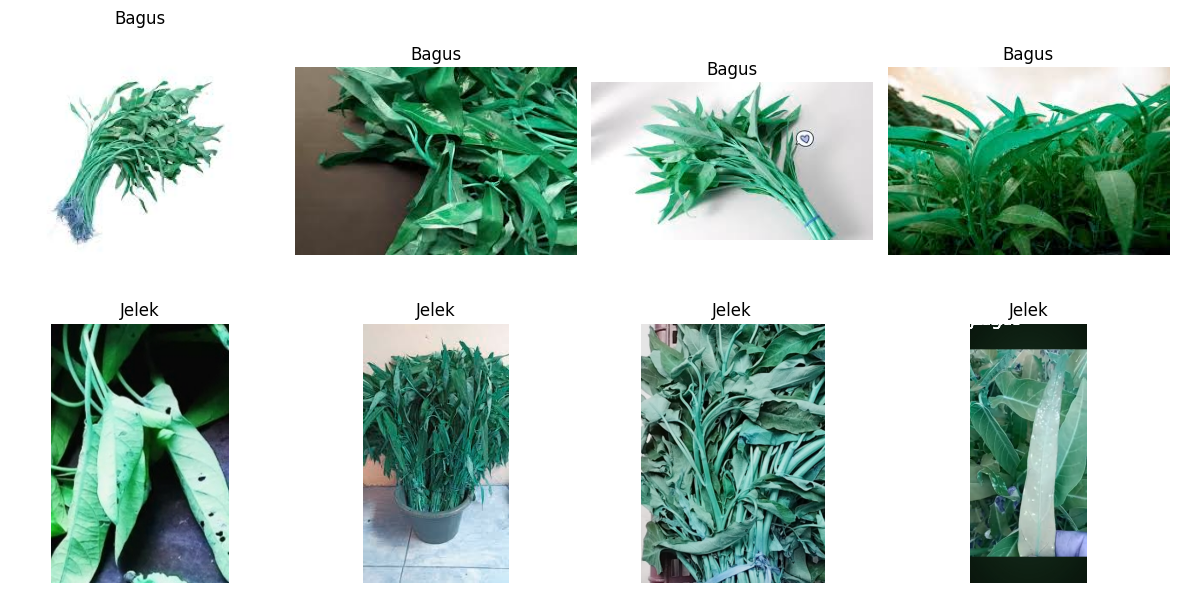

In [33]:
kangkung_bagus_path = '/kaggle/input/vegetables-quality-images/Vegetables/train/Kangkung Darat Bagus'
kangkung_jelek_path = '/kaggle/input/vegetables-quality-images/Vegetables/train/Kangkung Darat Jelek'

# Function untuk load and menampilkan image dengan label (grayscale conversion removed)
def display_image(path, label):
  # Read image using OpenCV
  img = cv2.imread(path)
  # Convert ke RGB format (if necessary)
  if img.shape[2] == 4:  # Check jika image mempunyai alpha channel
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
  # tamahkan label text
  plt.text(0, 0, label, color='white', fontsize=12)
  return img

# Display random kangkung images
num_images_to_display = 8  # Total images (4 bagus + 4 jelek)
kangkung_bagus_images = os.listdir(kangkung_bagus_path)
random.shuffle(kangkung_bagus_images)

kangkung_jelek_images = os.listdir(kangkung_jelek_path)
random.shuffle(kangkung_jelek_images)

# Create figure and subplots for 2x4 (baris X kolom) grid
fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 

# menampilkan bagus images
for i in range(4):
  image_path = os.path.join(kangkung_bagus_path, kangkung_bagus_images[i])
  label = "Bagus"
  img = display_image(image_path, label)
  axes[0, i].imshow(img)
  axes[0, i].axis('off')
  axes[0, i].set_title(label)

# menampikan jelek images 
for i in range(4):
  image_path = os.path.join(kangkung_jelek_path, kangkung_jelek_images[i])
  label = "Jelek"
  img = display_image(image_path, label)
  axes[1, i].imshow(img)
  axes[1, i].axis('off')
  axes[1, i].set_title(label)

# Adjust layout (optional)
fig.tight_layout()

plt.show()


ii. check bad images

In [34]:
train_path = '/kaggle/input/vegetables-quality-images/Vegetables/train'
val_path = '/kaggle/input/vegetables-quality-images/Vegetables/validation'
test_path = '/kaggle/input/vegetables-quality-images/Vegetables/test'

In [35]:
def check_images(path):
    for subdir, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                img = Image.open(file_path) # buka iamge file
                img.verify() # memverifikasi image
            except (IOError, SyntaxError) as e:
                print('Bad file:', file_path)

check_images(train_path)
check_images(val_path)
check_images(test_path)

# **PREPARE DATASET BINARY**

> Load the training dataset with generator and use augmentation

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20, # 20 derajat
    shear_range=0.1, # shear(penggeseran) images by 10% their size
    zoom_range=0.1,# Zoom in and out images by 10%
    fill_mode='nearest', # fill unlocated pixels by nearest pixel (Fills the empty pixels with the nearest pixel value from the valid part of the image.)
    horizontal_flip=True, # Allow horizontal flipping
    vertical_flip=True # Allow vertical flipping

)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    shuffle=False,
    class_mode='categorical',
    batch_size=32
)

Found 2069 images belonging to 58 classes.


> Load the validation dataset with generator and use augmentation

In [37]:
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    shuffle=False,
    class_mode='categorical',
    batch_size=32
)

Found 419 images belonging to 58 classes.


In [38]:
x, y = next(train_generator)
print("Labels:", y)
print("Images shape:", x.shape)


Labels: [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Images shape: (32, 224, 224, 3)


In [39]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
for key, value in class_map.items():
    print(f"{key} : {value}")

0 : Bayam Brazil Bagus
1 : Bayam Brazil Jelek
2 : Bayam Hijau Bagus
3 : Bayam Hijau Jelek
4 : Bayam Jepang Bagus
5 : Bayam Jepang Jelek
6 : Bayam Malabar atau Bayam India Bagus
7 : Bayam Malabar atau Bayam India Jelek
8 : Bayam Merah Bagus
9 : Bayam Merah Jelek
10 : Brokoli Hijau Italia Bagus
11 : Brokoli Hijau Italia Jelek
12 : Daun Beluntas Bagus
13 : Daun Beluntas Jelek
14 : Daun Ginseng Jawa Bagus
15 : Daun Ginseng Jawa Jelek
16 : Daun Katuk Bagus
17 : Daun Katuk Jelek
18 : Daun Kenikir Bagus
19 : Daun Kenikir Jelek
20 : Daun Pepaya Bagus
21 : Daun Pepaya Jelek
22 : Daun Pepaya Jepang Bagus
23 : Daun Pepaya Jepang Jelek
24 : Daun Singkong Bagus
25 : Daun Singkong Jelek
26 : Daun Ubi Jalar Bagus
27 : Daun Ubi Jalar Jelek
28 : Daun Kelor Bagus
29 : Daun Kelor Jelek
30 : Kangkung Darat Bagus
31 : Kangkung Darat Jelek
32 : Kecipir Bagus
33 : Kecipir Jelek
34 : Kembang Kol Bagus
35 : Kembang Kol Jelek
36 : Kubis Brussel Bagus
37 : Kubis Brussel Jelek
38 : Kubis Hijau Bagus
39 : Kubis Hi

# **BUILD CNN MODEL BINARY**

i. build model

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224,3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'), # tepi, tekstur dan edges
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu'), # bagian-bagian lebih besar
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu'), # bagian-bagian lebih besar
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=58, activation='softmax') 
])

ii. model diagram

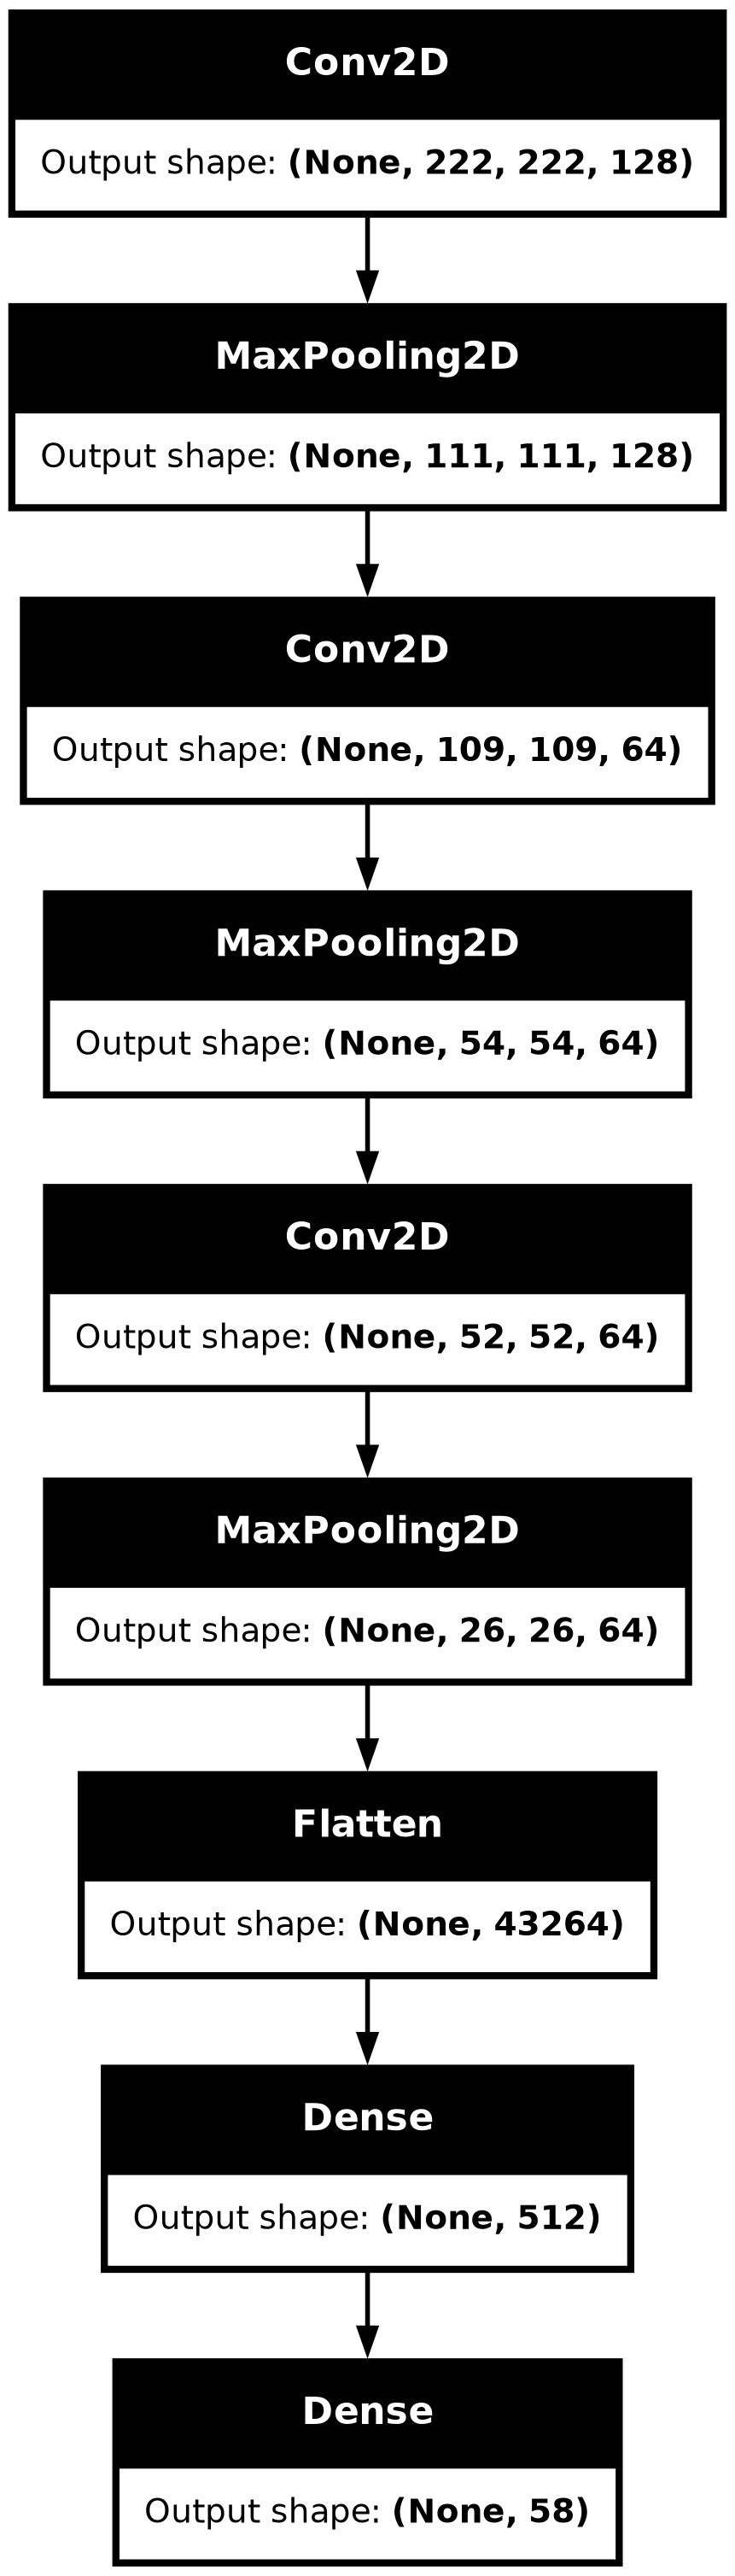

In [41]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [42]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 58)             │        29,754 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,295,738 (85.05 MB)

 Trainable params: 22,295,738 (85.05 MB)

 Non-trainable params: 0 (0.00 B)

iii. compile model

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

iv. training model

- jika batch=32, total sample=2069, epoch 20 maka,
->n Batch per Epoch = Total Sampel/Batch Size = 2069/32 = 65 batch
->Total Iterasi = 65 batch/epoch×20 epoch = 1300 iterasi

jadi, batch adalah sekumpulan sampel yang digunakan untuk mengupdate parameter model dalam satu iterasi selama proses pelatihan.

In [44]:
history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 299s 4s/step - accuracy: 7.6229e-04 - loss: 5.3920 - val_accuracy: 0.0644 - val_loss: 4.0552
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - accuracy: 0.0121 - loss: 4.0544 - val_accuracy: 0.0644 - val_loss: 4.0497
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 319s 4s/step - accuracy: 0.0837 - loss: 4.0573 - val_accuracy: 0.0644 - val_loss: 4.0442
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - accuracy: 0.0656 - loss: 4.0446 - val_accuracy: 0.0644 - val_loss: 4.0320
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 317s 4s/step - accuracy: 0.0300 - loss: 4.0366 - val_accuracy: 0.0692 - val_loss: 3.9711
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.0406 - loss: 4.1067 - val_accuracy: 0.0740 - val_loss: 4.0036
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 289s 4s/step - accuracy: 0.0642 - loss: 4.0804 - val_accuracy: 0.0692 - val_loss: 3.9902
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.0686 - loss: 4.0207 - val_accuracy: 0.0692

KeyboardInterrupt: 

# **PLOT RESULT DATA TRAINING**

In [ ]:
result_data = pd.DataFrame(history.history)
result_data.head()

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(train_accuracy, '-o', label='Train accuracy')
ax[0].plot(val_accuracy, '-o', label='Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].set_title('Loss vs Epochs')
ax[1].plot(train_loss, '-o', label='Train loss')
ax[1].plot(val_loss, '-o', label='Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

# **TEST MODEL**

In [ ]:
test_datagen = ImageDataGenerator(1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    shuffle=False,
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

In [ ]:
prediction = model.predict(test_generator)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
idx = 0 

for i in range(2):
    for j in range(5):
        prediction_class = class_map[np.argmax(prediction[idx])]
        ax[i, j].set_title(f"{prediction_class}")
        ax[i, j].imshow(test_generator[0][0][idx])
        idx += 1
        
plt.suptitle('Prediction Testing', fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

In [ ]:
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy} -> {100*test_accuracy:.2f}%")

# **PLOT TEST MODEL**

i. define y_hat and y

In [ ]:
y_hat = np.argmax(prediction, axis=1)
y_true = test_generator.classes

In [ ]:
# Hitung confusion matrix
cf_mtx = confusion_matrix(y_true, y_hat)

# Pisahkan menjadi dua bagian
num_classes = 58
mid_point = num_classes // 2

cf_mtx_part1 = cf_mtx[:mid_point, :mid_point]
cf_mtx_part2 = cf_mtx[mid_point:, mid_point:]

class_map_values = list(class_map.values())
class_labels_part1 = class_map_values[:mid_point]
class_labels_part2 = class_map_values[mid_point:]

def prepare_box_class(cf_mtx):
    group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
    box_class = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    return np.asarray(box_class).reshape(cf_mtx.shape)

box_class_part1 = prepare_box_class(cf_mtx_part1)
box_class_part2 = prepare_box_class(cf_mtx_part2)

plt.figure(figsize=(30, 50))  # Ukuran gambar yang besar untuk dua baris

# Heatmap untuk bagian pertama
plt.subplot(2, 1, 1)
sns.heatmap(cf_mtx_part1, xticklabels=class_labels_part1, yticklabels=class_labels_part1, cmap="YlGnBu", fmt="", annot=box_class_part1, annot_kws={"size": 12})
plt.xlabel('Predicted Classes', fontsize=20)
plt.ylabel('True Classes', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Part 1', fontsize=24)

# Heatmap untuk bagian kedua
plt.subplot(2, 1, 2)
sns.heatmap(cf_mtx_part2, xticklabels=class_labels_part2, yticklabels=class_labels_part2, cmap="YlGnBu", fmt="", annot=box_class_part2, annot_kws={"size": 12})
plt.xlabel('Predicted Classes', fontsize=20)
plt.ylabel('True Classes', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Part 2', fontsize=24)

plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_true, y_hat, target_names=class_map.values()))

# **WRONG PREDICTION**

In [ ]:
errors = (y_true - y_hat != 0)
y_true_errors = y_true[errors]
print(f'error: {errors}\n')
print(y_true_errors)
print(y_true_errors[0])
print(class_map[y_true_errors[idx]])

y_hat_errors = y_hat[errors]
print(y_hat_errors)
print(y_hat_errors[0])
print(class_map[y_hat_errors[idx]])

In [ ]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors] # mengambil images yang error

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_class = class_map[true_index]
        
        predicted_index = y_hat_errors[idx]
        predicted_class = class_map[predicted_index]
        
        ax[i, j].set_title(f"True Label: {true_class} \n Predicted Label: {predicted_class}")
        img_path = os.path.join(test_path, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()